# Lorenz96
For a number of variables $ J \in \mathbb{N} $, external force $ F \in \mathbb{R} $ and state variable $ \mathbb{u} \in \mathbb{R}^J $ on 1D periodic domain, the Lorenz 96 equation (Lorenz 1996) is given by

$$ \frac {du^{i}}{dt} =(u^{i+1}-u^{i-2})u^{i-1}-u^{i}+F, $$

with $ u^{-1} = u^{J-1} $, $ u^0 = u^J $, and $ u^{J+1} = u^1 $.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from da.l96 import lorenz96
from da.scheme import rk4
from da.loss import loss_rms
from da.visualize import plot_loss
from da.etkf import ETKF

In [3]:
# Lorenz96
# J: dim of state space
J = 40

# F: forcing
F = 8


## Generate the true trajectory

In [4]:
# generate data
# dt: time step size
dt = 0.01

# N: number of time steps, 2 years : 20*360*2 steps
N = 20*360*2 

# initial state near the statinary point
x0 = F*np.ones(J) # the statinary point
x0[19] *= 1.001 # perturb

# use my modules
scheme = rk4
p = (F, )

try:
    x_true = np.load("data/x_true_l96.npy")
except:
    result = np.zeros((N,len(x0)))
    x = x0
    result[0] = x[:]

    for n in range(1,N):
        t = n*dt
        x = scheme(lorenz96, t, x, p, dt)
        result[n] = x[:]


    x_true = result[360*20:][::5] # spin up 1 year and save per 6 hours
    print(x_true.shape)
    np.save(f"data/x_true_l96", x_true)

## DA setting

In [5]:
# assimilation period
Dt = 0.05

# Model function for EnKF
def M(x, Dt):
    for i in range(int(Dt/0.01)):
        x = rk4(lorenz96, 0, x, p, 0.01)
    return x

# 観測
H_diag = np.ones(J)
H = np.diag(H_diag)
print("diag of H", H_diag)
print("rank(H)", np.linalg.matrix_rank(H))

# Observation error covariance
r = 0.1**0.5
R = r**2*np.eye(J)

# random seed
seed = 0
np.random.seed(seed)

# generate observation
end_step = N//5//6 # for development
x_true = np.load('data/x_true_l96.npy')[:end_step]
y = (H@x_true.T).T
y += np.random.normal(loc=0, scale=r, size=y.shape) # R = r**2*I

# initial state for EnKF
x_0 = x_true[np.random.randint(len(x_true)-1)]

# P_0 = 25*np.eye(J)

# ensemble size
# m = 41

# deterministic ensemble
m = J+1
X_0 = np.zeros((J+1, J))
for i in range(J+1):
    if i == J:
       e = X_0[:J].sum(axis=0)
       X_0[J] = e
    else:
        e = np.zeros(J)
        e[i] = 1
        X_0[i] = e
X_0 *= 1
# inflation
# alpha = 1.5

diag of H [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
rank(H) 40


0.025641025641025595


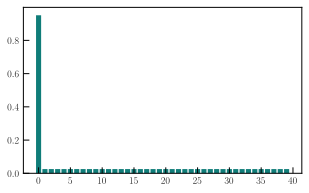

In [6]:
# eigen values of initial cov
dX_0 = X_0 - X_0.mean(axis=0, keepdims=True)
P_0 = dX_0.T @ (dX_0) / (J-1)

plt.bar(np.arange(J), sorted(np.linalg.eigvals(P_0), reverse=True))
print(min(np.linalg.eigvals(P_0)))

## Run DA over $\alpha$

In [15]:
import scipy as sp
alpha_list = [1.0, 1.1, 5.0]
# paramname = "m(41)-alpha(1.0=1.5=2.0)"
paramname = "m(41)-alpha(1.0=1.1=5.0)"
try:
    # raise
    xa_alpha = np.load(f"data/xa_alpha-{paramname}.npy")
    evals_alpha = np.load(f"data/evals_alpha-{paramname}.npy")
except:
    evals_alpha = []
    xa_alpha = []
    for alpha in alpha_list:
        etkf = ETKF(M, H, R, alpha=alpha, store_ensemble=True)
        etkf.initialize(X_0)
        for y_obs in y:
            etkf.forecast(Dt)
            etkf.update(y_obs)

        xa_alpha.append(etkf.x)

        Pf = []
        for X in etkf.X_f:
            dX = X - X.mean(axis=0, keepdims=True)
            P = dX.T @ (dX) / (J-1)
            Pf.append(P)
        evals = np.array([sorted(sp.linalg.eigvals(Pf_t).real, reverse=True) for Pf_t in Pf])
        evals_alpha.append(evals)

    np.save(f"data/xa_alpha-{paramname}", xa_alpha)
    np.save(f"data/evals_alpha-{paramname}", evals_alpha)

## Theoretical error bound
For each time, let $ \bar{v}, u \in \mathbb{R}^J $ be the analysis mean and true state respectively.
### SE(Square Error)
$$ \text{SE} = \sum_{i=1}^J |v^i - u^i|^2 $$
Theoretical bound of SE: `Jr^2` $ \sim $ observarion SE ($ m\gamma^2 $ in the paper).

##### ※RMSE(Root Mean Square Error)
$ \text{RMSE} = \left(\frac{1}{J} \sum_{i=1}^J |v^i - u^i|^2\right)^{1/2} $, theoretical bound of RMSE: `r` $ \approx $ observarion RMSE ($ \gamma $ in the paper).

## Plot errors and minimum eigenvalues

In [8]:
def loss_sq(X, Y):
    """
    X, Y: (T, J)
    """
    return np.sum((X-Y)**2, axis=1)

In [79]:
# from visualize import get_color_palette, get_linestyle_cycle, get_marker_cycle
# # Plot
# per_vis = 4 # NOTE: plot RMSE per 4 time steps (1time step:6h)
# per_ticklabel = per_vis * 20

# lw = 1
# # --------------

# fig, axes = plt.subplots(2, 1, figsize=(9,6))

# num_alpha = len(alpha_list)
# colors = get_color_palette(num_alpha, "flare")
# line_cycle = get_linestyle_cycle()
# marker_cycle = get_marker_cycle()

# time_ticks = np.arange(len(xa_alpha[0])//per_vis)*per_vis
# time_ticklabels = np.arange(len(xa_alpha[0])//per_ticklabel+1)*per_ticklabel
# for i, xa in enumerate(xa_alpha):
#     alpha = alpha_list[i]
#     evals = evals_alpha[i]

#     color = colors[i]
#     ls = next(line_cycle)
#     marker = next(marker_cycle)

#     # plot square error of analysis
#     plot_loss(x_true[::per_vis], xa[::per_vis], loss_sq, x_index=time_ticks, ax=axes[0], label=f"ETKF $\\alpha$={alpha}", lw=lw, color=color, ls=ls, marker=marker)

#     # plot minimum eigenvalues of prediction ensemble covariance
#     axes[1].plot(time_ticks, evals[:, -1][::per_vis], label=f"ETKF $\\alpha$={alpha}", lw=lw, color=color, ls=ls, marker=marker)

# # plot square error of observation
# plot_loss((H@x_true.T).T[::per_vis], y[::per_vis], loss_sq, x_index=time_ticks, ax=axes[0], label='observation', lw=lw, c="k")


# axes[0].set_ylabel("log SE")
# axes[0].set_yscale("log")
# axes[0].legend(bbox_to_anchor=(1, 1), loc='upper right')
# axes[0].set_xticks(time_ticklabels)
# axes[0].set_xticklabels(time_ticklabels)

# axes[1].set_xlabel("time step")
# axes[1].set_ylabel("$\\log\\hat{\\lambda}_{min}$")
# axes[1].set_yscale("log")
# axes[1].set_xticks(time_ticklabels)
# axes[1].set_xticklabels(time_ticklabels)
# axes[1].legend(bbox_to_anchor=(1, 1), loc='upper right')
# fig.tight_layout()

In [36]:
xa.shape

(480, 40)

In [45]:
len(x_true[::4])

120

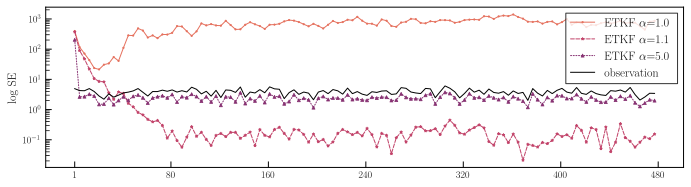

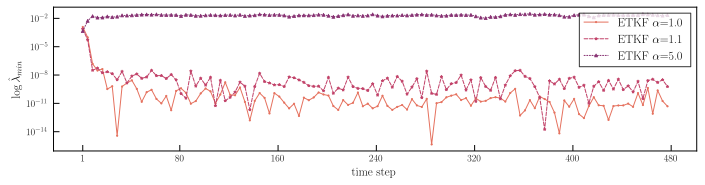

In [58]:
from visualize import get_color_palette, get_linestyle_cycle, get_marker_cycle
# Plot
per_vis = 4 # NOTE: plot RMSE per 4 time steps (1time step:6h)
per_ticklabel = per_vis * 20

lw = 1
# --------------

fig1, ax1 = plt.subplots(figsize=(10,3))
fig2, ax2 = plt.subplots(figsize=(10.2,3))

num_alpha = len(alpha_list)
colors = get_color_palette(num_alpha, "flare")
line_cycle = get_linestyle_cycle()
marker_cycle = get_marker_cycle()

time_ticks = np.arange(len(xa_alpha[0])//per_vis)*per_vis + 1
time_ticklabels = np.arange(len(xa_alpha[0])//per_ticklabel+1)*per_ticklabel
time_ticklabels[0] = 1
for i, xa in enumerate(xa_alpha):
    alpha = alpha_list[i]
    evals = evals_alpha[i]

    color = colors[i]
    ls = next(line_cycle)
    marker = next(marker_cycle)

    # plot square error of analysis
    plot_loss(x_true[::per_vis], xa[::per_vis], loss_sq, x_index=time_ticks, ax=ax1, label=f"ETKF $\\alpha$={alpha}", lw=lw, color=color, ls=ls, marker=marker)

    # plot minimum eigenvalues of prediction ensemble covariance
    ax2.plot(time_ticks, evals[:, -1][::per_vis], label=f"ETKF $\\alpha$={alpha}", lw=lw, color=color, ls=ls, marker=marker)

# plot square error of observation
plot_loss((H@x_true.T).T[::per_vis], y[::per_vis], loss_sq, x_index=time_ticks, ax=ax1, label='observation', lw=lw, c="k")

ax1.set_ylabel("log SE")
ax1.set_yscale("log")
ax1.legend(bbox_to_anchor=(1, 1), loc='upper right')
ax1.set_xticks(time_ticklabels)
ax1.set_xticklabels(time_ticklabels)
# ax1.grid()
fig1.tight_layout()

ax2.set_xlabel("time step")
ax2.set_ylabel("$\\log\\hat{\\lambda}_{min}$")
ax2.set_yscale("log")
ax2.set_xticks(time_ticklabels)
ax2.set_xticklabels(time_ticklabels)
ax2.legend(bbox_to_anchor=(1, 1), loc='upper right')
fig2.tight_layout()

# save fig
fig1.savefig("data/l96-etkf-inflation_se.pdf", transparent=True)
fig2.savefig("data/l96-etkf-inflation_eval.pdf", transparent=True)

In [ ]:
x_true

In [29]:
x_true[::4][0]- x_true[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [28]:
print(len(x_true[::4]))
len(time_ticks)

120


120

In [1]:
from visualize import get_color_palette, get_linestyle_cycle, get_marker_cycle
# Plot
per_vis = 4 # NOTE: plot RMSE per 4 time steps (1time step:6h)
per_ticklabel = per_vis * 20

lw = 1
# --------------
idx1 = 1
idx2 = 39

fig1, ax1 = plt.subplots(figsize=(10,3))
fig2, ax2 = plt.subplots(figsize=(10.2,3))
fig3, ax3 = plt.subplots(figsize=(10.2,3))

num_alpha = len(alpha_list)
colors = get_color_palette(num_alpha, "flare")
line_cycle = get_linestyle_cycle()
marker_cycle = get_marker_cycle()

time_ticks = np.arange(len(xa_alpha[0])//per_vis)*per_vis + 1
time_ticklabels = np.arange(len(xa_alpha[0])//per_ticklabel+1)*per_ticklabel + 1
for i, xa in enumerate(xa_alpha):
    alpha = alpha_list[i]
    evals = evals_alpha[i]

    color = colors[i]
    ls = next(line_cycle)
    marker = next(marker_cycle)

    # plot square error of analysis
    plot_loss(x_true[::per_vis], xa[::per_vis], loss_sq, x_index=time_ticks, ax=ax1, label=f"ETKF $\\alpha$={alpha}", lw=lw, color=color, ls=ls, marker=marker)

    # plot minimum eigenvalues of prediction ensemble covariance
    ax2.plot(time_ticks, evals[:, idx1][::per_vis], label=f"ETKF $\\alpha$={alpha}", lw=lw, color=color, ls=ls, marker=marker)
    ax3.plot(time_ticks, evals[:, idx2][::per_vis], label=f"ETKF $\\alpha$={alpha}", lw=lw, color=color, ls=ls, marker=marker)

# plot square error of observation
plot_loss((H@x_true.T).T[::per_vis], y[::per_vis], loss_sq, x_index=time_ticks, ax=ax1, label='observation', lw=lw, c="k")

ax1.set_ylabel("log SE")
ax1.set_yscale("log")
ax1.legend(bbox_to_anchor=(1, 1), loc='upper right')
ax1.set_xticks(time_ticklabels)
ax1.set_xticklabels(time_ticklabels)
fig1.tight_layout()

ax2.set_xlabel("time step")
ax2.set_ylabel("$\\log\\hat{\\lambda}_{"+f"{idx1+1}"+"}$")
ax2.set_yscale("log")
ax2.set_ylim([1e-7, 1])
ax2.set_xticks(time_ticklabels)
ax2.set_xticklabels(time_ticklabels)
ax2.legend(bbox_to_anchor=(1, 1), loc='upper right')
fig2.tight_layout()

ax3.set_xlabel("time step")
ax3.set_ylabel("$\\log\\hat{\\lambda}_{"+f"{idx2+1}"+"}$")
ax3.set_yscale("log")
ax3.set_ylim([1e-7, 1])
ax3.set_xticks(time_ticklabels)
ax3.set_xticklabels(time_ticklabels)
ax3.legend(bbox_to_anchor=(1, 1), loc='upper right')
fig3.tight_layout()


NameError: name 'plt' is not defined

In [121]:
h = dt*5
eps = 1e-6
rho = np.sqrt(2*J)*F
beta = np.sqrt(max([32*rho**2, 4]))
a = 8*(m/(m-1))*beta*rho**2
lam0 = sorted(np.linalg.eigvals(P_0), reverse=True)[-1]
# alpha0 = max([lam0**(-0.5)*r*np.exp(a*h)*(np.exp((beta + eps)*h)-1), np.exp((a + beta + eps)*h)])

# -------
beta1 = (rho - 1)
dv0 = 0.01
min([np.exp(beta1*5*1e-2)*dv0, 2*rho])

0.34045871054671806